In [1]:
'''
Before running cell blocks below, requires running biot_savart.py 
(option #1 in main()) to generate total ground magnetic field files
'''

import os
#os.environ['PATH'] = "/wrk-vakka/group/spacephysics/proj/appl/tex-basic/texlive/2023/bin/x86_64-linux:" + os.environ['PATH']
print(os.environ["PATH"])


import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import ftest as ft
import pytools as pt
#from numba import jit
from myutils import cartesian_to_spherical_vector, spherical_to_cartesian, mkdir_path, timer

R_EARTH = 6371000.

run = "FHA"  # FHA, FIA, EGL
if run == "FIA":
    dir = "/wrk-vakka/group/spacephysics/vlasiator/3D/FIA/bulk_sidecars/ig_B"
elif run == "FHA":
    dir = "/wrk-vakka/group/spacephysics/vlasiator/3D/FHA/bulk1_sidecars/ig_B"
elif run == "EGL":
    dir = "/wrk-vakka/group/spacephysics/vlasiator/3D/EGL/sidecars/ig_B"
f = ft.f("/wrk-vakka/group/spacephysics/vlasiator/3D/FHA/bulk1_sidecars/ig_B/ionosphere_B_sidecar_FHA.0000784.vlsv")
f.list()
#plt.plot([1,2])
#plt.show()



/proj/horakons/conda/myconda/bin:/wrk-vakka/turso/home/horakons/proj/.vscode-server/bin/6c3e3dba23e8fadc360aed75ce363ba185c49794/bin/remote-cli:/appl/easybuild/opt/Anaconda3/2022.05:/appl/easybuild/opt/Anaconda3/2022.05/sbin:/proj/horakons/conda/myconda/bin:/appl/easybuild/opt/ImageMagick/7.1.0-37-GCCcore-11.3.0/bin:/appl/easybuild/opt/LittleCMS/2.13.1-GCCcore-11.3.0/bin:/appl/easybuild/opt/JasPer/2.0.33-GCCcore-11.3.0/bin:/appl/easybuild/opt/Ghostscript/9.56.1-GCCcore-11.3.0/bin:/appl/easybuild/opt/GTK2/2.24.33-GCCcore-11.3.0/bin:/appl/easybuild/opt/Pango/1.50.7-GCCcore-11.3.0/bin:/appl/easybuild/opt/FriBidi/1.0.12-GCCcore-11.3.0/bin:/appl/easybuild/opt/HarfBuzz/4.2.1-GCCcore-11.3.0/bin:/appl/easybuild/opt/ICU/71.1-GCCcore-11.3.0/sbin:/appl/easybuild/opt/ICU/71.1-GCCcore-11.3.0/bin:/appl/easybuild/opt/Gdk-Pixbuf/2.42.8-GCCcore-11.3.0/bin:/appl/easybuild/opt/LibTIFF/4.3.0-GCCcore-11.3.0/bin:/appl/easybuild/opt/libdeflate/1.10-GCCcore-11.3.0/bin:/appl/easybuild/opt/zstd/1.5.2-GCCcore-11

KeyboardInterrupt: 

In [3]:
#@timer
#@jit(nopython=True)
def E_horizontal(dB_dt, pos, time, sigma = 1e-3):
    '''
        Calculate the horizontal electric field by integrating components of dB/dt 
            References: Cagniard et al 1952 (eq. 12), Pulkinnen et al 2006 (eq. 19)
        Inputs:
            dB_dt: cartesian dB/dt    [T/s] array dimension [3, len(time)]
            pos: cartesian position [m] 1D 3-element array, vector position
            time: 1D array of times [s]

        Keywords:
            sigma = ground conductivity (siemens/meter)
    '''
    mu_0 = 1.25663706e-6    # permeability of free space
    E_north = np.zeros(time.size)
    E_east = np.zeros(time.size)
    dB_dt_r, dB_dt_theta, dB_dt_phi = cartesian_to_spherical_vector(dB_dt[0,:], dB_dt[1,:], dB_dt[2,:], pos[0], pos[1], pos[2])
    dB_dt_north = -dB_dt_theta; dB_dt_east = dB_dt_phi
    t0 = time[1] - time[0]
    for i in range(1, time.size):
        # Possible upgrade to the integration would be to fit the dB/dt time-series to a polynomial first 
        # and integrate that exactly over the finite time domain
        t = time[i]
        tp = time[1:i+1]          
        dt = tp - time[0:i]
        # general equation for E (e.g., Pulkinnen et al. 2005, eq. 19. Note in their formula there is a typo (comparing with Cagniard 1952): should be dB/dt not dB/dt')
        E_north[i] = -(1. / np.sqrt(np.pi * mu_0 * sigma)) * np.sum(dt * dB_dt_east[1:i+1] / np.sqrt(t-tp + t0))
        E_east[i] = (1. / np.sqrt(np.pi * mu_0 * sigma)) * np.sum(dt * dB_dt_north[1:i+1] / np.sqrt(t-tp + t0))  # note the sign
    return E_north, E_east



i_pos = 0
E_north, E_east = E_horizontal(ig_dB_dt_arr[i_pos,:,:], pos[i_pos,:], time, sigma = 1e-3)

In [4]:

if run == "FHA":
    nmin = 1001    # 1001
    nmax = 1612    # 1100
elif run == "FIA":
    nmin = 1
    nmax = 817         #865 (files 818-819 missing)
elif run == "EGL":
    nmin = 621
    nmax = 1760
time = np.linspace(nmin, nmax, nmax - nmin + 1)

pos = f.read_variable('ig_r')   # ionospheric grid.  array dimensions (43132, 3)
#ig_B_arr = np.ndarray([pos.shape[0], pos.shape[1], nmax - nmin + 1])
ig_dB_dt_arr = np.ndarray([pos.shape[0], pos.shape[1], nmax - nmin + 1])
ig_B_ionosphere_arr = ig_dB_dt_arr * 0.
ig_dB_dt_ionosphere_arr = ig_dB_dt_arr * 0.
ig_B_inner_arr = ig_dB_dt_arr * 0.
ig_dB_dt_inner_arr = ig_dB_dt_arr * 0.
ig_B_outer_arr = ig_dB_dt_arr * 0.
ig_dB_dt_outer_arr = ig_dB_dt_arr * 0.

E_north_arr = np.ndarray([pos.shape[0], nmax - nmin + 1])
E_east_arr = np.ndarray([pos.shape[0], nmax - nmin + 1])

#populate B arrays
for i in range(nmin, nmax+1):
    #print(i)
    f = ft.f(dir + "/ionosphere_B_sidecar_{}.{}.vlsv".format(run, str(i).zfill(7)))     # FHA: file indices 501 - 1612
    try:
        ig_B_ionosphere = f.read_variable('ig_B_ionosphere')
        ig_B_ionosphere_arr[:,:,i-nmin] = ig_B_ionosphere
    except:
        print("couldn't read ionospheric data") # for runs without an ionosphere, leave as zeros
    ig_B_inner = f.read_variable('ig_B_inner')
    ig_B_inner_arr[:,:,i-nmin] = ig_B_inner
    ig_B_outer = f.read_variable('ig_B_outer')
    ig_B_outer_arr[:,:,i-nmin] = ig_B_outer

# interpolate across zeros in B arrays (missing data points, something funny about FHA and FIA makes ionosphere write operation unreliable?)
#for arr in [ig_B_arr, ig_B_ionosphere_arr, ig_B_inner_arr, ig_B_outer_arr]:

for arr in [ig_B_ionosphere_arr]:
    try:
        #reduced_arr = np.sum(arr, 0)
        #ind = np.where(reduced_arr[0,:] != 0)[0]
        ind = np.where(arr[0,0,:] != 0)[0]
        print("{} points removed".format(arr.shape[2] - ind.size))
        interp_arr = arr[:,:, ind]  # only keep the non-zero times to conduct the interpolation
        for i in range(arr.shape[0]): # positions
            for j in range(3): # vector components
                arr[i, j, :] = np.interp(time, time[ind], interp_arr[i, j, :], left=None, right=None, period=None)
    except:
        print("error with interpolation. zeroing out array...")

ig_B_arr =  ig_B_ionosphere_arr + ig_B_inner_arr + ig_B_outer_arr

# calculate dB/dt and populate corresponding arrays
for i in range(nmin, nmax+1):
    #next compute derivatives
    if i>nmin:
        ig_dB_dt_arr[:,:,i-nmin] = ig_B_arr[:,:,i-nmin] - ig_B_arr[:,:,i-nmin-1]
        ig_dB_dt_ionosphere_arr[:,:,i-nmin] = ig_B_ionosphere_arr[:,:,i-nmin] - ig_B_ionosphere_arr[:,:,i-nmin-1]
        ig_dB_dt_inner_arr[:,:,i-nmin] = ig_B_inner_arr[:,:,i-nmin] - ig_B_inner_arr[:,:,i-nmin-1]
        ig_dB_dt_outer_arr[:,:,i-nmin] = ig_B_outer_arr[:,:,i-nmin] - ig_B_outer_arr[:,:,i-nmin-1]


#i_pos = 0
#E_north, E_east = E_horizontal(ig_dB_dt_arr[i_pos,:,:], pos[i_pos,:], time, sigma = 1e-3)
for i_pos in range(ig_dB_dt_arr.shape[0]):
    E_north, E_east = E_horizontal(ig_dB_dt_arr[i_pos,:,:], pos[i_pos,:], time, sigma = 1e-3)
    E_north_arr[i_pos,:] = E_north
    E_east_arr[i_pos,:] = E_east
    print(i_pos)

Error: variable cellid/VARIABLE/SpatialGrid/pass not found in .vlsv file or in data reducers!
Error: variable cellid/VARIABLE/SpatialGrid/pass not found in .vlsv file or in data reducers!
Error: variable cellid/VARIABLE/SpatialGrid/pass not found in .vlsv file or in data reducers!
Error: variable cellid/VARIABLE/SpatialGrid/pass not found in .vlsv file or in data reducers!
Error: variable cellid/VARIABLE/SpatialGrid/pass not found in .vlsv file or in data reducers!
Error: variable cellid/VARIABLE/SpatialGrid/pass not found in .vlsv file or in data reducers!
Error: variable cellid/VARIABLE/SpatialGrid/pass not found in .vlsv file or in data reducers!
Error: variable cellid/VARIABLE/SpatialGrid/pass not found in .vlsv file or in data reducers!
Error: variable cellid/VARIABLE/SpatialGrid/pass not found in .vlsv file or in data reducers!
Error: variable cellid/VARIABLE/SpatialGrid/pass not found in .vlsv file or in data reducers!
Error: variable cellid/VARIABLE/SpatialGrid/pass not found i

KeyboardInterrupt: 

In [ ]:
# write geoelectric field to .vlsv

save_dir = '/wrk-vakka/users/horakons/carrington/data/{}/GIC/'.format(run)
f_iono = pt.vlsvfile.VlsvReader( '/wrk-vakka/group/spacephysics/vlasiator/temp/ionogrid_FHA.vlsv' )

for i, t in enumerate(time):
    # write to file
    filename_vlsv = save_dir + 'ionosphere_gic_{}_{}.vlsv'.format(run, str(int(t)).zfill(7))
    mkdir_path(filename_vlsv)
    writer = pt.vlsvfile.VlsvWriter(f_iono, filename_vlsv)
    writer.write(pos,'ig_r','VARIABLE','ionosphere')
    writer.write(E_north_arr[:,i],'ig_E_north','VARIABLE','ionosphere')
    writer.write(E_east_arr[:,i],'ig_E_east','VARIABLE','ionosphere')


Error: variable xcells_ini/PARAMETER//pass not found in .vlsv file or in data reducers!


In [ ]:
# Plot timeseries of the geoelectric field at different latitudes

plt.rcParams["figure.figsize"] = (10, 6)

lat_deg = np.arange(60, 91, 1)
lat = lat_deg * np.pi / 180.
theta = (np.pi / 2) - lat
phi = lat * 0

x0, y0, z0 = spherical_to_cartesian(R_EARTH, theta, phi)
print(x0.size)
for i in range(x0.size):
    # Find nearest neighbor of the ionosphere grid, index by 'ind_min', to the specified lat and phi
    dist = np.sqrt((x0[i] - pos[:,0])**2 + (y0[i] - pos[:,1])**2 + (z0[i] - pos[:,2])**2) 
    ind_min = np.argmin(dist)
    # print(lat[i] )
    print(z0[i])
    print(pos[ind_min,2])
    print(lat_deg[i], np.nanmax(1e6 * E_north_arr[ind_min,:]))
    # PLOT:
    # geoelectic field
    plt.title('GIC Lat. = {} deg., noon, {}'.format(int(lat_deg[i]), run))
    plt.xlabel('time [sec]')
    plt.ylabel(r'Geoelectric field [$\mu$V/m]')
    plt.plot(time, 1e6 * E_north_arr[ind_min,:], label = r'northward E [$\mu$V/m]')
    plt.plot(time, 1e6 * E_east_arr[ind_min,:], label = r'eastward E [$\mu$V/m]')
    plt.ylim([-400, 400])
    plt.legend()
    filename =  '/wrk-vakka/users/horakons/carrington/plots/{}/GIC/geolectric_E_timeseries_lat_{}_{}'.format(run,int(lat_deg[i]),run)
    mkdir_path(filename)
    plt.savefig(filename)
    plt.close()
    # dB/dt
    plt.title('dB/dt Lat. = {} deg., noon, {}'.format(int(lat_deg[i]), run))
    plt.xlabel('time [sec]')
    plt.ylabel(r'Ground magnetic field [nT/s]]')
    dB_dt_r, dB_dt_theta, dB_dt_phi = cartesian_to_spherical_vector(ig_dB_dt_arr[ind_min, 0,:], ig_dB_dt_arr[ind_min,1,:], ig_dB_dt_arr[ind_min, 2,:], pos[ind_min, 0], pos[ind_min,1], pos[ind_min, 2])
    dB_dt_north = -dB_dt_theta; dB_dt_east = dB_dt_phi
    plt.plot(time, 1e9 * dB_dt_north, label = r'northward dB/dt [nT/s]')
    plt.plot(time, 1e9 * dB_dt_east, label = r'eastward dB/dt [nT/s]')
    plt.ylim([-8, 8])
    plt.legend()
    filename =  '/wrk-vakka/users/horakons/carrington/plots/{}/GIC/dB_dt_timeseries_lat_{}_{}'.format(run,int(lat_deg[i]),run)
    mkdir_path(filename)
    plt.savefig(filename)
    plt.close()
    # |dB/dt| (components)
    try: # won't work for EGL?
        plt.title('dB/dt Lat. = {} deg., noon, {}'.format(int(lat_deg[i]), run))
        plt.xlabel('time [sec]')
        plt.ylabel(r'Ground magnetic field [nT/s]]')
        dB_dt_r_ionosphere, dB_dt_theta_ionosphere, dB_dt_phi_ionosphere = cartesian_to_spherical_vector(ig_dB_dt_ionosphere_arr[ind_min, 0,:], ig_dB_dt_arr[ind_min,1,:], ig_dB_dt_arr[ind_min, 2,:], pos[ind_min, 0], pos[ind_min,1], pos[ind_min, 2])
        dB_dt_north_ionosphere = -dB_dt_theta_ionosphere; dB_dt_east_ionosphere = dB_dt_phi_ionosphere
        dB_dt_r_inner, dB_dt_theta_inner, dB_dt_phi_inner = cartesian_to_spherical_vector(ig_dB_dt_inner_arr[ind_min, 0,:], ig_dB_dt_inner_arr[ind_min,1,:], ig_dB_dt_inner_arr[ind_min, 2,:], pos[ind_min, 0], pos[ind_min,1], pos[ind_min, 2])
        dB_dt_north_inner = -dB_dt_theta_inner; dB_dt_east_inner = dB_dt_phi_inner
        dB_dt_r_outer, dB_dt_theta_outer, dB_dt_phi_outer = cartesian_to_spherical_vector(ig_dB_dt_outer_arr[ind_min, 0,:], ig_dB_dt_outer_arr[ind_min,1,:], ig_dB_dt_outer_arr[ind_min, 2,:], pos[ind_min, 0], pos[ind_min,1], pos[ind_min, 2])
        dB_dt_north_outer = -dB_dt_theta_outer; dB_dt_east_outer = dB_dt_phi_outer
        plt.plot(time, np.abs(1e9 * np.sqrt(dB_dt_north**2 + dB_dt_east**2) ), label = r'total |dB/dt| [nT/s]')
        plt.plot(time, np.abs(1e9 * np.sqrt(dB_dt_north_ionosphere**2 + dB_dt_east_ionosphere**2) ), label = r'ionospheric |dB/dt| [nT/s]')
        plt.plot(time, np.abs(1e9 * np.sqrt(dB_dt_north_inner**2 + dB_dt_east_inner**2) ), label = r'inner |dB/dt| [nT/s]')
        plt.plot(time, np.abs(1e9 * np.sqrt(dB_dt_north_outer**2 + dB_dt_east_outer**2) ), label = r'outer |dB/dt| [nT/s]')
        plt.ylim([-8, 8])
        plt.legend()
        filename =  '/wrk-vakka/users/horakons/carrington/plots/{}/GIC/component_dB_dt_timeseries_lat_{}_{}'.format(run,int(lat_deg[i]),run)
        mkdir_path(filename)
        plt.savefig(filename)
        plt.close()
    except:
        print("can't plot components!")    

31
5517447.847510658
5596451.184804648
60 101.79653736433137
5572202.15418509
5662111.819998548
61 108.57478885157349
5625259.114104223
5719644.049454975
62 118.84608231261109
5676602.565604092
5764124.7473510215
63 120.50202360728966
5726216.868971993
5821651.257651471
64 122.90636136749436
5774086.911210497
5875956.378118976
65 134.7374129396375
5820198.110641011
5919446.75608563
66 143.67182718565758
5864536.421345497
5950653.668000988
67 144.9260148014752
5907088.337445003
5996304.732174632
68 148.34571475829642
5947840.897213672
6038532.396700564
69 159.10024708441549
5986781.687027022
6081158.519772296
70 164.16697175055893
6023898.845143247
6110712.8793279
71 169.1812786995747
6059181.065316423
6153067.196629294
72 181.62333103190284
6092617.6002405
6194691.377078991
73 187.5356248690246
6124198.26482303
6222805.321171675
74 194.54391812925473
6153913.439287654
6250115.604152898
75 199.8576920573929
6181754.072104374
6277204.01088344
76 203.04756070085014
6207711.682746734
63034

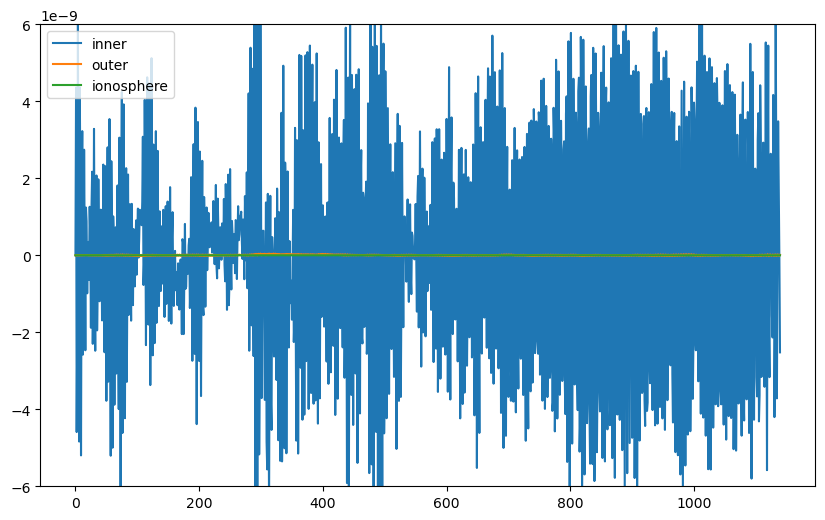

In [ ]:
E_north
#plt.plot(E_east_arr[12,:])
plt.plot(ig_dB_dt_inner_arr[55,0,:], label = 'inner')
plt.plot(ig_dB_dt_outer_arr[55,0,:], label = 'outer')
plt.plot(ig_dB_dt_ionosphere_arr[55,0,:], label = 'ionosphere')
plt.legend()
plt.ylim([-6e-9, 6e-9])
plt.show()

In [ ]:
ig_dB_dt_arr[0,:,0]

array([0., 0., 0.])

In [ ]:

E_east_arr.shape

(43132, 1140)

In [ ]:

pos.shape

(43132, 3)

In [ ]:
spherical_to_cartesian(R_EARTH,0 ,0 )

(0.0, 0.0, 6371000.0)

In [ ]:
ig_dB_dt_arr.shape

(43132, 3, 1140)

In [ ]:
pos.shape

(43132, 3)